In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

from sklearn import preprocessing
from sklearn.feature_selection import  SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## Training Data - import and preprocessing

In [2]:
#!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
    
df = pd.read_csv('loan_train.csv')
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

y = df['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(Feature.astype(float), y, test_size=0.2)
SC = preprocessing.StandardScaler().fit(X_train) 
X_train = SC.transform(X_train)
X_test = SC.transform(X_test)

## KNN

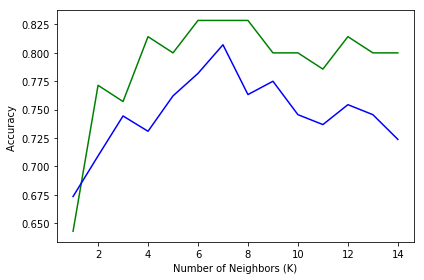

Best k =  6 
KNN Jaccard index: 0.8285714285714286 
KNN F1-score: 0.7819124423963134


In [3]:
K = 15
knn_jss_acc = np.zeros([K-1])
knn_f1_acc = np.zeros([K-1])

for n in range(1,K):
    
    knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    knn_yhat = knn.predict(X_test)

    knn_jss_acc[n-1] = jaccard_similarity_score(y_test, knn_yhat)
    knn_f1_acc[n-1] = f1_score(y_test, knn_yhat, average='weighted')
    
best_k = knn_jss_acc.argmax()+1

plt.plot(range(1,K),knn_jss_acc,'g',range(1,K), knn_f1_acc, 'b')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

knn = KNeighborsClassifier(n_neighbors = best_k).fit(X_train,y_train)
knn.fit(X_train, y_train)
knn_yhat = knn.predict(X_test)

print('Best k = ',best_k,
      "\nKNN Jaccard index:", jaccard_similarity_score(y_test, knn_yhat),
      "\nKNN F1-score:", f1_score(y_test, knn_yhat, average='weighted'))


## Decision Tree

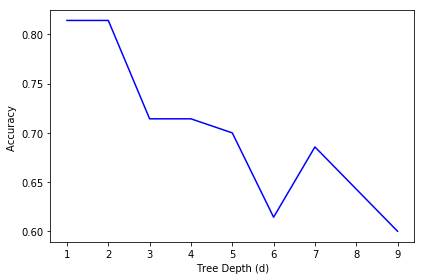

Best tree depth =  2 
SVM Jaccard index: 0.8142857142857143 
SVM F1-score: 0.7309336332958379


In [4]:
d=10
dt_jss = np.zeros([d-1])
best_d = 0
maxjss = 0

for n in range(1,d):
    
    dt = DecisionTreeClassifier(criterion = "entropy", max_depth = n)
    dt.fit(X_train, y_train)
    dt_yhat = dt.predict(X_test)
    dt_jss[n-1] = jaccard_similarity_score(y_test, dt_yhat)
    if jaccard_similarity_score(y_test, dt_yhat) >= maxjss:
        maxjss = jaccard_similarity_score(y_test, dt_yhat)
        best_d = n
    
plt.plot(range(1,d),dt_jss,'b')
plt.ylabel('Accuracy ')
plt.xlabel('Tree Depth (d)')
plt.tight_layout()
plt.show()

dt = DecisionTreeClassifier(criterion = "entropy", max_depth = best_d).fit(X_train, y_train)
dt_yhat = dt.predict(X_test)

print( "Best tree depth = ", best_d,
      "\nSVM Jaccard index:", jaccard_similarity_score(y_test, dt_yhat),
      "\nSVM F1-score:", f1_score(y_test, dt_yhat, average='weighted'))

## SVM

In [5]:
estimators = ['linear', 'rbf', 'poly', 'sigmoid']
par = [0.01, 0.1, 1.0, 10]
maxf1 = 0
best_model = ''
best_c = 1.0
best_g = 1.0

for e in estimators:
    for c in par:
        svc = svm.SVC(kernel = e, C=c).fit(X_train, y_train)
        yhat = svc.predict(X_test)
        if f1_score(y_test, yhat, average='weighted') > maxf1:
            maxf1 = f1_score(y_test, yhat, average='weighted')
            best_model = e
            best_c = c
            
for g in par:
    svc = svm.SVC(kernel = best_model, C=best_c, gamma=g).fit(X_train, y_train)
    svm_yhat = svc.predict(X_test)
    if f1_score(y_test, svm_yhat, average='weighted') > maxf1:
        best_g=g

svc = svm.SVC(kernel = best_model, C=best_c, gamma=best_g).fit(X_train, y_train)
svm_yhat = svc.predict(X_test)

print("Best Model:", best_model,
      "\nBest C:", best_c,
      "\nBest Gamma:", best_g,
      "\nSVM Jaccard index:", jaccard_similarity_score(y_test, svm_yhat),
      "\nSVM F1-score:", f1_score(y_test, svm_yhat, average='weighted'))

Best Model: sigmoid 
Best C: 10 
Best Gamma: 1.0 
SVM Jaccard index: 0.8 
SVM F1-score: 0.8053571428571429


## Logistic Regression

In [6]:
par = [0.01, 0.1, 1.0, 10, 100]
models = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_jss=0
best_m=''
best_c=0

for m in models:
    for c in par:
        LR = LogisticRegression(solver=m, C=c).fit(X_train,y_train)
        LR_yhat = LR.predict(X_test)
        if jaccard_similarity_score(y_test, yhat) >= max_jss:
            max_jss=jaccard_similarity_score(y_test, yhat)
            best_c=c
            best_m=m
        #print(m,c,jaccard_similarity_score(y_test, yhat))

LR = LogisticRegression(solver= best_m, C=best_c).fit(X_train,y_train)
LR_yhat = LR.predict(X_test)
LR_yhat_prob = LR.predict_proba(X_test)

print("Best Model:", best_m,
      "\nBest C:", best_c,
      "\nLR Jaccard index:", jaccard_similarity_score(y_test, LR_yhat),
      "\nLR F1-score:", f1_score(y_test, LR_yhat, average='weighted'),
      "\nLR LogLoss:", log_loss(y_test, LR_yhat_prob))

Best Model: saga 
Best C: 100 
LR Jaccard index: 0.8571428571428571 
LR F1-score: 0.8392857142857144 
LR LogLoss: 0.43036478409557133


## Testing Data - import and preprocessing

In [7]:
df_test = pd.read_csv('loan_test.csv')
df_test['due_date'] = pd.to_datetime(df['due_date'])
df_test['effective_date'] = pd.to_datetime(df['effective_date'])
df_test['dayofweek'] = df_test['effective_date'].dt.dayofweek
df_test['weekend'] = df_test['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df_test['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df_test['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

Feature_test = df_test[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(df_test['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

ty = df_test['loan_status'].values
tX = preprocessing.StandardScaler().fit(Feature_test).transform(Feature_test)

In [8]:
knn_yhat = knn.predict(tX)
print("KNN Jaccard index:", jaccard_similarity_score(ty, knn_yhat))
print("KNN F1-score:", f1_score(ty, knn_yhat, average='weighted'))

KNN Jaccard index: 0.7037037037037037
KNN F1-score: 0.6579124579124579


In [9]:
dt_yhat = dt.predict(tX)
print("DT Jaccard index:", jaccard_similarity_score(ty, dt_yhat))
print("DT F1-score:", f1_score(ty, dt_yhat, average='weighted'))

DT Jaccard index: 0.7407407407407407
DT F1-score: 0.6304176516942475


In [10]:
svm_yhat = svc.predict(tX)
print("SVM Jaccard index:", jaccard_similarity_score(ty, svm_yhat))
print("SVM F1-score:", f1_score(ty, svm_yhat, average='weighted'))

SVM Jaccard index: 0.6111111111111112
SVM F1-score: 0.580278488206877


In [11]:
LR_yhat = LR.predict(tX)
LR_yhat_prob = LR.predict_proba(tX)
print("LR Jaccard index:", jaccard_similarity_score(ty, LR_yhat))
print("LR F1-score:", f1_score(ty, LR_yhat, average='weighted'))
print("LR LogLoss:", log_loss(ty, LR_yhat_prob))

LR Jaccard index: 0.7407407407407407
LR F1-score: 0.6304176516942475
LR LogLoss: 0.578000956202735


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.70    | 0.64     | NA      |
| Decision Tree      | 0.74    | 0.63     | NA      |
| SVM                | 0.61    | 0.58     | NA      |
| LogisticRegression | 0.74    | 0.63     | 0.57    |